Author: Yann Charbon <yann.charbon@heig-vd.ch>

In [1]:
from DAGDatasetGenerator import DAGDatasetGenerator
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import community as community_louvain

generator = DAGDatasetGenerator()

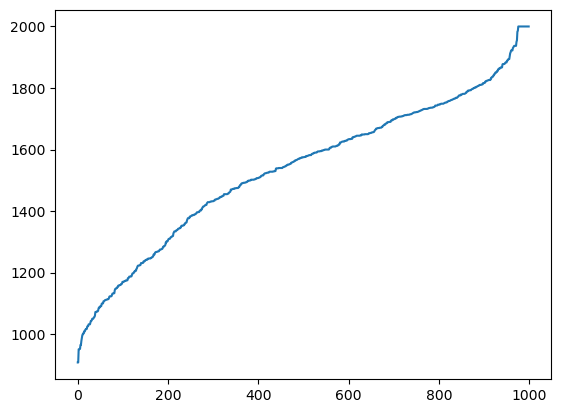

In [209]:
dags, perfs, adj_matrix = generator.run_once_double_flux(21, keep_dags_count=1000, keep_random_dags=True, max_steps=2000)

perfs = np.asarray(perfs)
dags = np.asarray(dags)
sorted_indices = np.argsort(perfs)
perfs_sorted = perfs[sorted_indices]
dags_sorted = dags[sorted_indices]

fig = plt.figure()
plt.plot(perfs_sorted)
plt.show()

In [210]:
#dag, perf = generator.evaluate_dag_performance_double_flux(dags_sorted[100], adj_matrix, 2)
#print(perf)
#dag, perf = generator.evaluate_dag_performance_double_flux(dags_sorted[200], adj_matrix, 2)
#print(perf)
#dag, perf = generator.evaluate_dag_performance_double_flux(dags_sorted[101], adj_matrix, 2)
#print(perf)
#dag, perf = generator.evaluate_dag_performance_double_flux(dags_sorted[201], adj_matrix, 2)
#print(perf)

[2, 4, 8, 1, 7, 1, 1, 3, 2, 4, 5, 5, 6, 4, 3, 2, 2, 3, 3, 4]
20


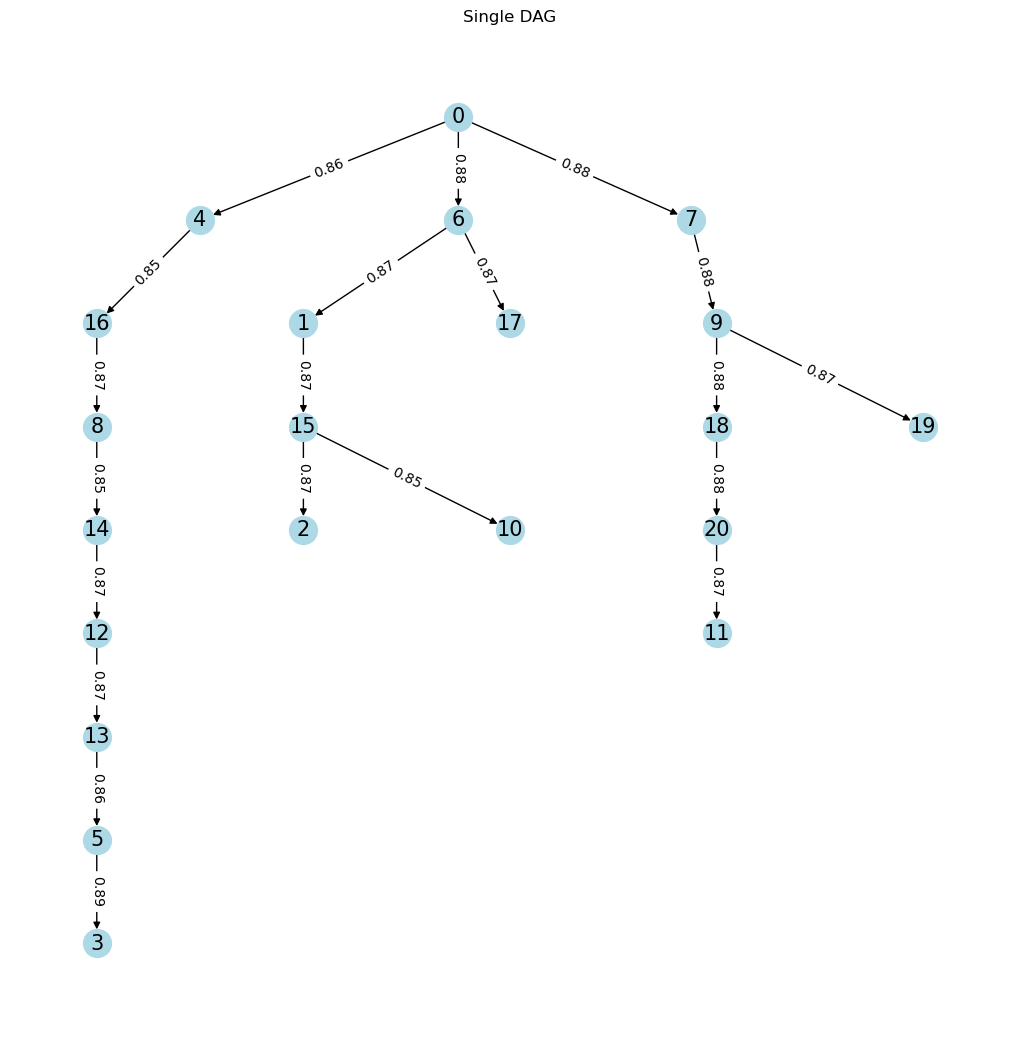

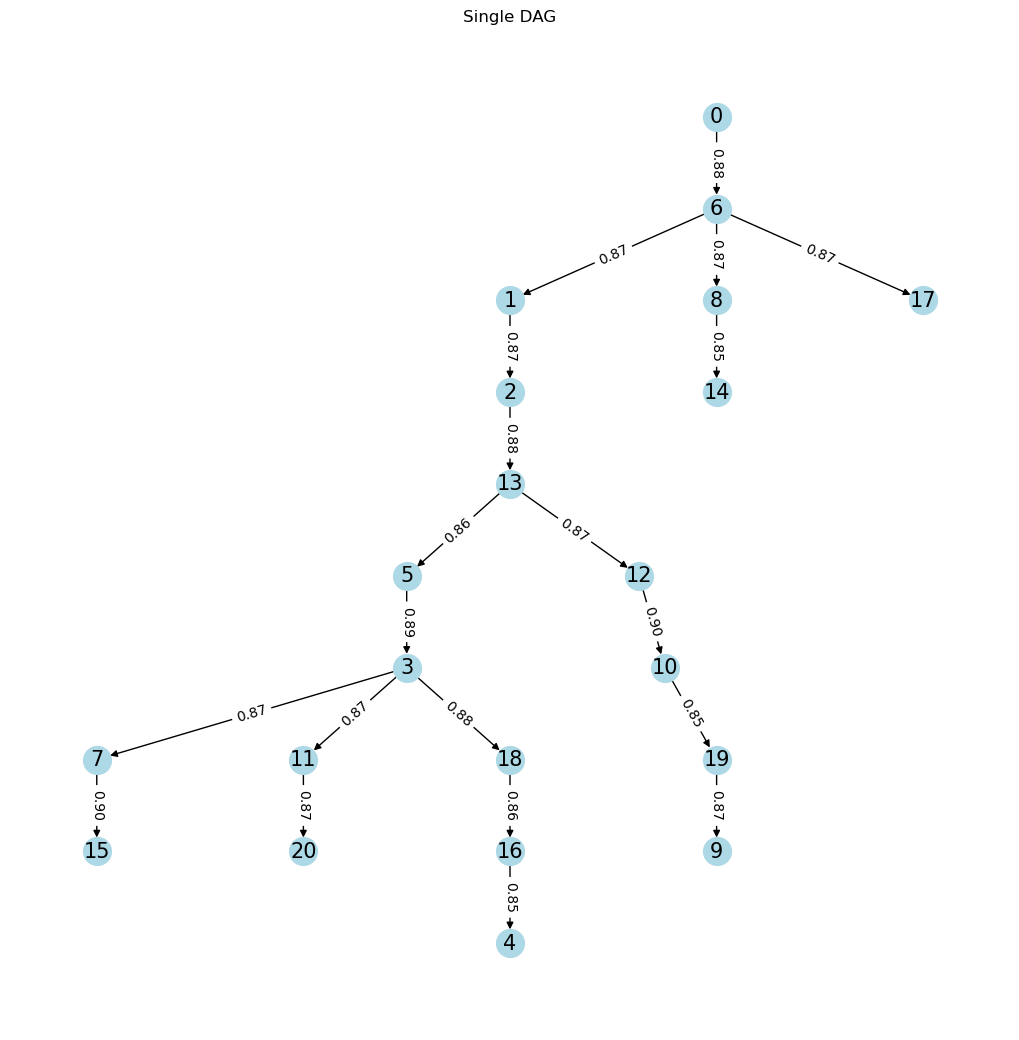

In [211]:
G: nx.DiGraph = nx.DiGraph()
G.add_edges_from(dags[0])

ranks = [ nx.shortest_path_length(G, target=node, source=0) for node in range(1, len(dags[0]) + 1) ]
print(ranks)
print (len(ranks))


generator.draw_dag(dags_sorted[0], adj_matrix)
generator.draw_dag(dags_sorted[-1], adj_matrix)



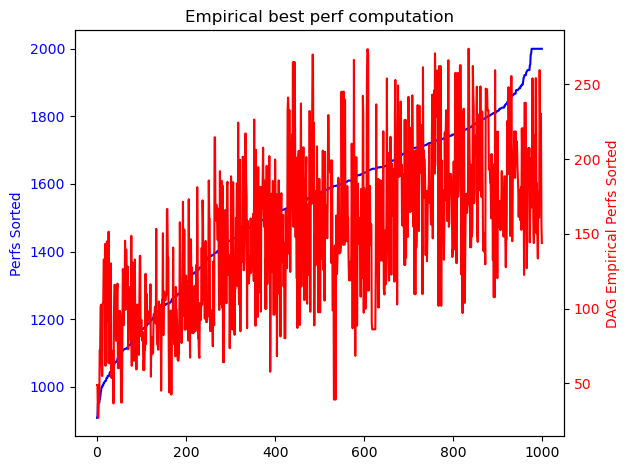

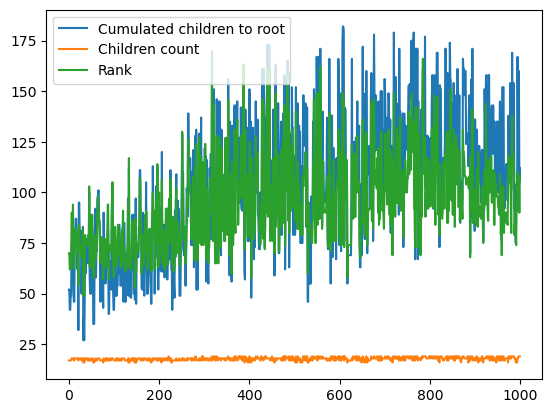

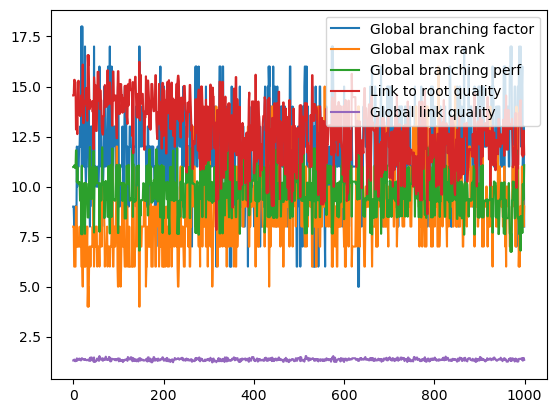

best_empirical_perf = 26.84469334283031 @ 2


In [226]:
def compute_empirical_perf(G: nx.DiGraph, adj_matrix):
    def get_nodes_at_rank(G: nx.DiGraph, rank: int):
        # Compute shortest path lengths from the source
        path_lengths = nx.single_source_shortest_path_length(G, 0)

        # Filter nodes by the specified rank
        nodes_at_rank = [node for node, length in path_lengths.items() if length == rank]

        return nodes_at_rank

    def get_max_rank(G: nx.DiGraph):
        max_rank = 0
        path_lengths = nx.single_source_shortest_path_length(G, 0)
        for node in range(0, len(G.nodes)):
            if path_lengths[node] > max_rank:
                max_rank = path_lengths[node]
        return max_rank

    def compute_weighted_branching_factor(G: nx.DiGraph):
        score = 0
        rank = 0
        nodes_at_rank = get_nodes_at_rank(G, rank)
        while nodes_at_rank != []:
            for node in nodes_at_rank:
                children_count = len(list(G.successors(node)))
                if children_count > 1:
                    score += children_count# * rank
            rank += 1
            nodes_at_rank = get_nodes_at_rank(G, rank)

        return score

    def compute_global_branching_performance(G: nx.DiGraph, adj_matrix):
        global_branching_perf = 0
        for node in range(0, len(G.nodes)):
            branching_perf = 1

            children = list(G.successors(node))
            if len(children) == 0:
                continue

            for child in children:
                branching_perf *= adj_matrix[node][child]
            if node > 0:
                parent = list(G.predecessors(node))[0]
                branching_perf *= adj_matrix[parent][node]

            global_branching_perf += branching_perf

        return global_branching_perf

    def compute_global_link_quality(G: nx.DiGraph, adj_matrix):
        global_link_quality = 1.0
        for node in range(1, len(G.nodes)):
            parent = list(G.predecessors(node))[0]
            global_link_quality *= adj_matrix[parent][node]
        return global_link_quality * len(G.nodes)

    def cluster_dag_with_louvain(dag: nx.DiGraph):
        # Convert the DAG to an undirected graph
        undirected_graph = nx.Graph()
        for u, v, data in dag.edges(data=True):
            weight = data.get('weight', 1)  # Use edge weight if available, else default to 1
            if undirected_graph.has_edge(u, v):
                undirected_graph[u][v]['weight'] += weight  # Aggregate weights
            else:
                undirected_graph.add_edge(u, v, weight=weight)

        # Apply the Louvain method
        partition = community_louvain.best_partition(undirected_graph, weight='weight')

        return partition

    def compute_perf_for_one_node(node, G: nx.DiGraph, adj_matrix):
        rank = nx.shortest_path_length(G, target=node, source=0)

        done = False
        parent = 0
        child = node
        link_to_root_quality = 1.0
        cumulated_link_to_root_children_count = 0
        while not done:
            parent = list(G.predecessors(child))[0]
            if parent == 0:
                done = True
                break
            link_to_root_quality *= adj_matrix[parent][child]
            cumulated_link_to_root_children_count += len(list(G.successors(child)))

            child = parent

        children_count = len(list(G.successors(node)))

        #score = #(100 * link_to_root_quality / ((cumulated_link_to_root_children_count + 1) + rank**4))
        #score = (link_to_root_quality / rank **3) / (cumulated_link_to_root_children_count + 1)**2 / (children_count + 1)**2
        #if children_count > 1:
        #    score = (children_count**7 + children_count**5 * rank +  cumulated_link_to_root_children_count * rank)
        #else:
        #    score = 0

        return cumulated_link_to_root_children_count, children_count, rank, link_to_root_quality

    global_score = 0
    global_cumulated_link_to_root_children_count = 0
    global_children_count = 0
    global_rank = 0
    global_link_to_root_quality = 0

    for node in range(1, len(dags[0]) + 1):
        cumulated_link_to_root_children_count, children_count, rank, link_to_root_quality = compute_perf_for_one_node(node, G, adj_matrix)

        global_score += cumulated_link_to_root_children_count + rank + children_count + link_to_root_quality

        global_cumulated_link_to_root_children_count += cumulated_link_to_root_children_count
        global_children_count += children_count
        global_rank += rank
        global_link_to_root_quality += link_to_root_quality

    louvain_clusters_count = len(cluster_dag_with_louvain(G))
    branching_factor = compute_weighted_branching_factor(G)
    max_rank = get_max_rank(G)
    global_branching_perf = compute_global_branching_performance(G, adj_matrix)
    global_link_quality = compute_global_link_quality(G, adj_matrix)

    #global_score += louvain_clusters_count**2
    global_score += branching_factor
    global_score += max_rank
    global_score -= global_branching_perf**2
    global_score -= global_link_quality

    return global_score, global_cumulated_link_to_root_children_count, global_children_count, global_rank, louvain_clusters_count, branching_factor, max_rank, global_branching_perf, global_link_to_root_quality, global_link_quality


dag_empirical_perfs = []
dag_empirical_global_cumulated_link_to_root_children_count = []
dag_empirical_global_children_count = []
dag_empirical_global_rank = []
dag_empirical_global_louvain_clusters_count = []
dag_empirical_global_branching_factor = []
dag_empirical_global_max_rank = []
dag_empirical_global_global_branching_perf = []
dag_empirical_link_to_root_quality = []
dag_empirical_global_link_quality = []

for dag in dags:

    G: nx.DiGraph = nx.DiGraph()
    G.add_edges_from(dag)

    global_score, global_cumulated_link_to_root_children_count, global_children_count, global_rank, global_louvain_cluster_count, global_branching_factor, global_max_rank, global_branching_perf, link_to_root_quality, global_link_quality = compute_empirical_perf(G, adj_matrix)
    dag_empirical_perfs.append(global_score)
    dag_empirical_global_cumulated_link_to_root_children_count.append(global_cumulated_link_to_root_children_count)
    dag_empirical_global_children_count.append(global_children_count)
    dag_empirical_global_rank.append(global_rank)
    dag_empirical_global_louvain_clusters_count.append(global_louvain_cluster_count)
    dag_empirical_global_branching_factor.append(global_branching_factor)
    dag_empirical_global_max_rank.append(global_max_rank)
    dag_empirical_global_global_branching_perf.append(global_branching_perf)
    dag_empirical_link_to_root_quality.append(link_to_root_quality)
    dag_empirical_global_link_quality.append(global_link_quality)


dag_empirical_perfs = np.asarray(dag_empirical_perfs)
dag_empirical_perfs_sorted = dag_empirical_perfs[sorted_indices]

dag_empirical_global_cumulated_link_to_root_children_count = np.asarray(dag_empirical_global_cumulated_link_to_root_children_count)[sorted_indices]
dag_empirical_global_children_count = np.asarray(dag_empirical_global_children_count)[sorted_indices]
dag_empirical_global_rank = np.asarray(dag_empirical_global_rank)[sorted_indices]
dag_empirical_global_louvain_clusters_count = np.asarray(dag_empirical_global_louvain_clusters_count)[sorted_indices]
dag_empirical_global_branching_factor = np.asarray(dag_empirical_global_branching_factor)[sorted_indices]
dag_empirical_global_max_rank = np.asarray(dag_empirical_global_max_rank)[sorted_indices]
dag_empirical_global_global_branching_perf = np.asarray(dag_empirical_global_global_branching_perf)[sorted_indices]
dag_empirical_link_to_root_quality = np.asarray(dag_empirical_link_to_root_quality)[sorted_indices]
dag_empirical_global_link_quality = np.asarray(dag_empirical_global_link_quality)[sorted_indices]

# Create the figure and first axis
fig, ax1 = plt.subplots()

# Plot the first dataset on the primary y-axis
ax1.plot(perfs_sorted, color='b', label='Perfs Sorted')
ax1.set_ylabel('Perfs Sorted', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot the second dataset on the secondary y-axis
ax2.plot(dag_empirical_perfs_sorted, color='r', label='DAG Empirical Perfs Sorted')
ax2.set_ylabel('DAG Empirical Perfs Sorted', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Add a title and show the plot
plt.title('Empirical best perf computation')
fig.tight_layout()  # Adjust layout to prevent overlap
plt.show()

plt.figure()
plt.plot(dag_empirical_global_cumulated_link_to_root_children_count, label="Cumulated children to root")
plt.plot(dag_empirical_global_children_count, label="Children count")
plt.plot(dag_empirical_global_rank, label="Rank")
plt.legend()
plt.show()

plt.figure()
#plt.plot(dag_empirical_global_louvain_clusters_count, label="Global Louvain clusters count")
plt.plot(dag_empirical_global_branching_factor, label="Global branching factor")
plt.plot(dag_empirical_global_max_rank, label="Global max rank")
plt.plot(dag_empirical_global_global_branching_perf, label="Global branching perf")
plt.plot(dag_empirical_link_to_root_quality, label="Link to root quality")
plt.plot(dag_empirical_global_link_quality, label="Global link quality")
plt.legend()
plt.show()

min_index = np.argmin(dag_empirical_perfs_sorted)
print(f"best_empirical_perf = {dag_empirical_perfs_sorted[min_index]} @ {min_index}")

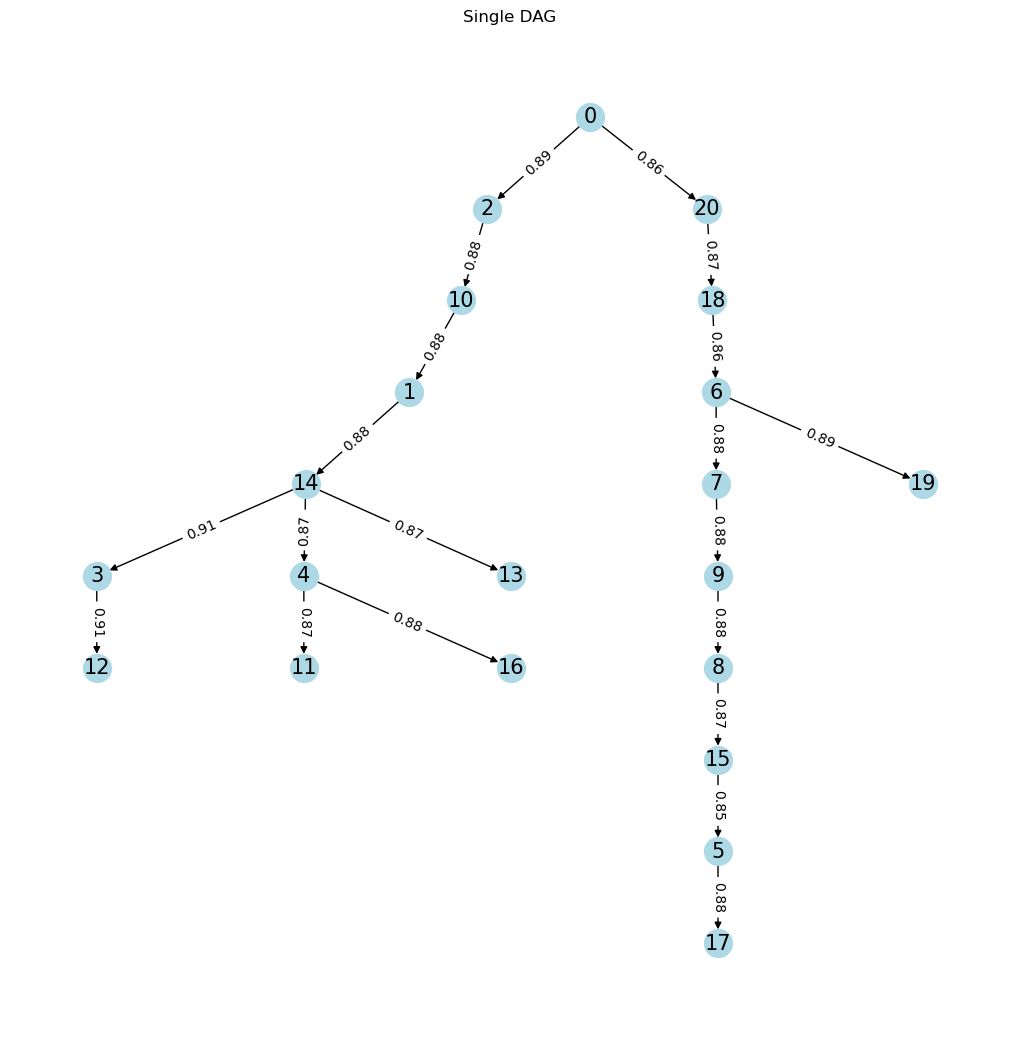

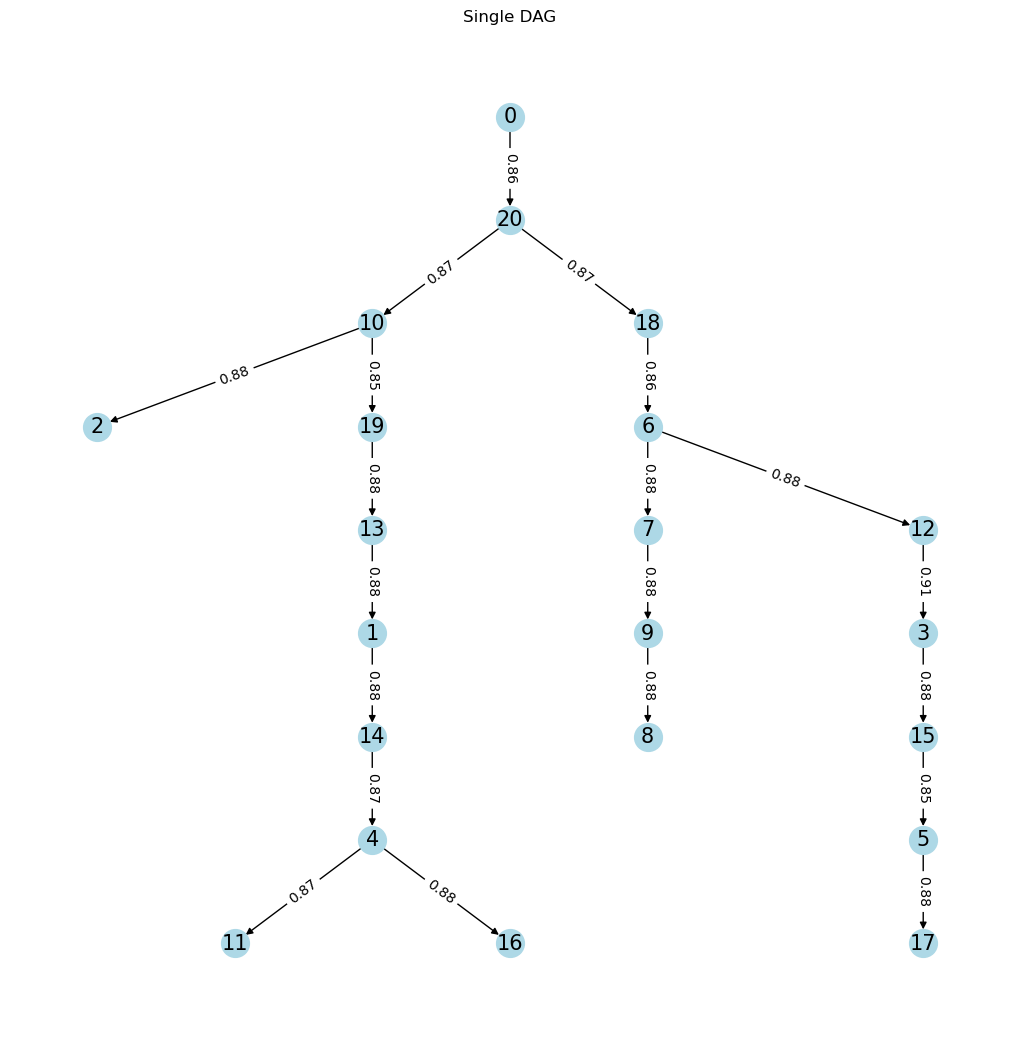

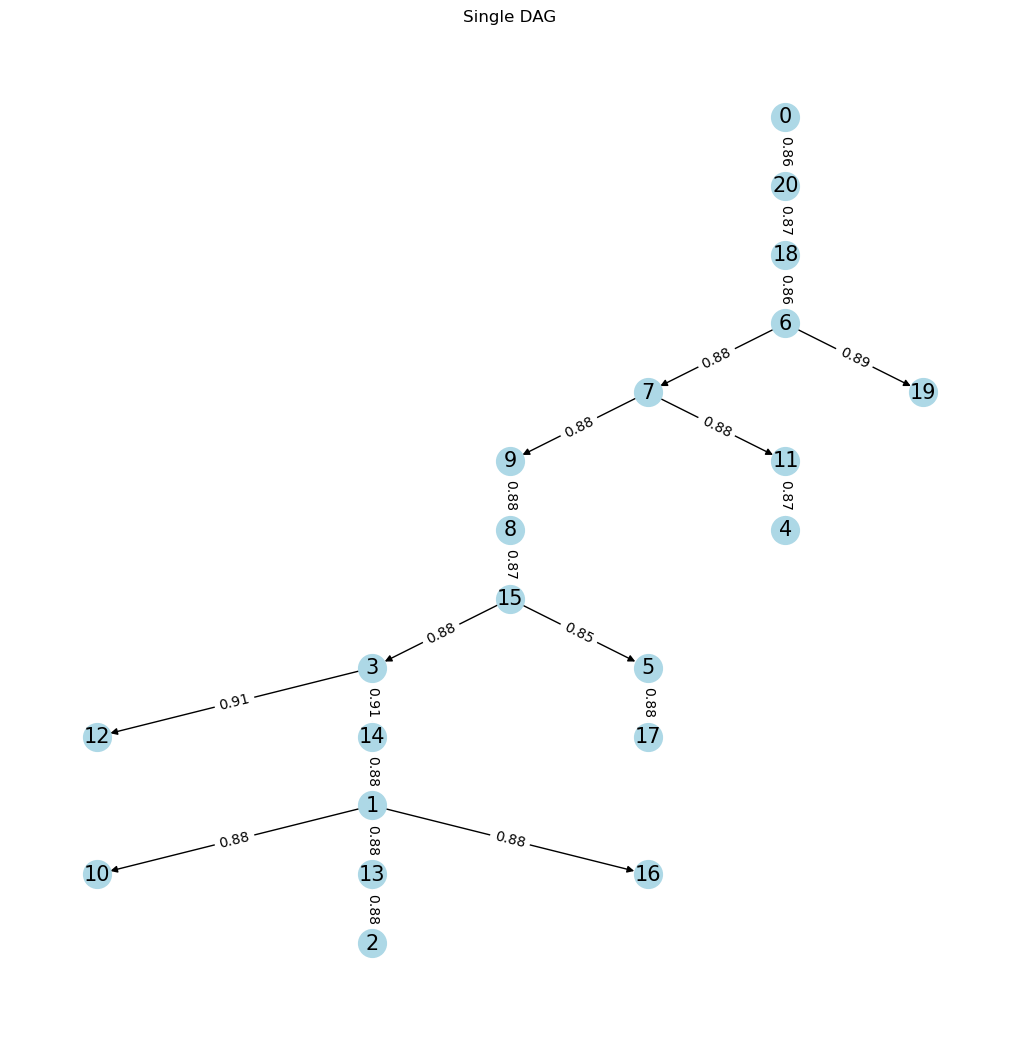

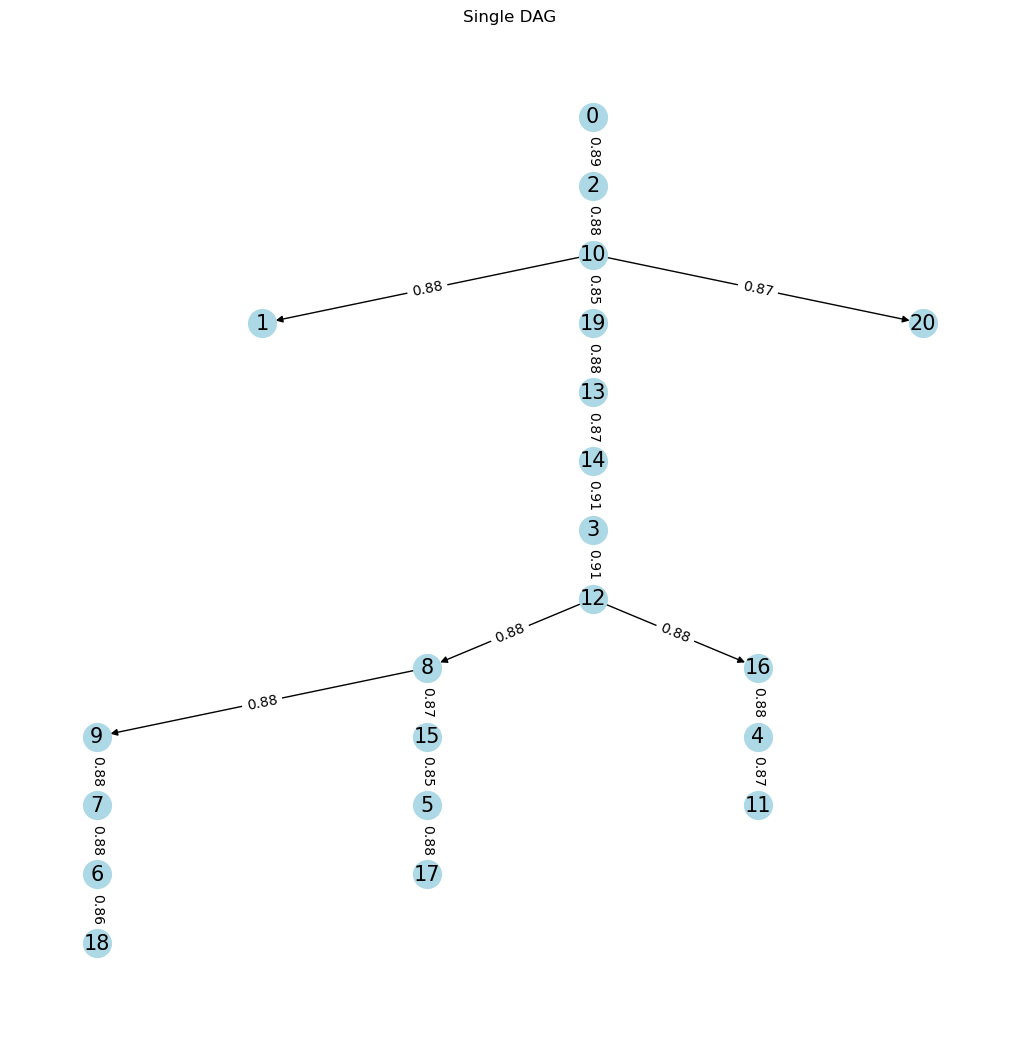

In [189]:
generator.draw_dag(dags_sorted[0], adj_matrix)
generator.draw_dag(dags_sorted[min_index], adj_matrix)
generator.draw_dag(dags_sorted[max_index], adj_matrix)
generator.draw_dag(dags_sorted[-1], adj_matrix)

In [ ]:
# Alternate version with a bit less variance

def compute_empirical_perf(G: nx.DiGraph, adj_matrix):
    def get_nodes_at_rank(G: nx.DiGraph, rank: int):
        # Compute shortest path lengths from the source
        path_lengths = nx.single_source_shortest_path_length(G, 0)

        # Filter nodes by the specified rank
        nodes_at_rank = [node for node, length in path_lengths.items() if length == rank]

        return nodes_at_rank

    def get_max_rank(G: nx.DiGraph):
        max_rank = 0
        path_lengths = nx.single_source_shortest_path_length(G, 0)
        for node in range(0, len(G.nodes)):
            if path_lengths[node] > max_rank:
                max_rank = path_lengths[node]
        return max_rank

    def compute_weighted_branching_factor(G: nx.DiGraph):
        score = 0
        rank = 0
        nodes_at_rank = get_nodes_at_rank(G, rank)
        while nodes_at_rank != []:
            for node in nodes_at_rank:
                children_count = len(list(G.successors(node)))
                if children_count > 1:
                    score += children_count# * rank
            rank += 1
            nodes_at_rank = get_nodes_at_rank(G, rank)

        return score

    def compute_global_branching_performance(G: nx.DiGraph, adj_matrix):
        global_branching_perf = 0
        for node in range(0, len(G.nodes)):
            branching_perf = 1

            children = list(G.successors(node))
            if len(children) == 0:
                continue

            for child in children:
                branching_perf *= adj_matrix[node][child]
            if node > 0:
                parent = list(G.predecessors(node))[0]
                branching_perf *= adj_matrix[parent][node]

            global_branching_perf += branching_perf

        return global_branching_perf

    def compute_global_link_quality(G: nx.DiGraph, adj_matrix):
        global_link_quality = 1.0
        max_rank = get_max_rank(G)
        for node in range(1, len(G.nodes)):
            parent = list(G.predecessors(node))[0]
            rank = nx.shortest_path_length(G, target=node, source=0)
            global_link_quality /= adj_matrix[parent][node]**2
        return global_link_quality / len(G.nodes)

    def cluster_dag_with_louvain(dag: nx.DiGraph):
        # Convert the DAG to an undirected graph
        undirected_graph = nx.Graph()
        for u, v, data in dag.edges(data=True):
            weight = data.get('weight', 1)  # Use edge weight if available, else default to 1
            if undirected_graph.has_edge(u, v):
                undirected_graph[u][v]['weight'] += weight  # Aggregate weights
            else:
                undirected_graph.add_edge(u, v, weight=weight)

        # Apply the Louvain method
        partition = community_louvain.best_partition(undirected_graph, weight='weight')

        return partition

    def compute_perf_for_one_node(node, G: nx.DiGraph, adj_matrix):
        rank = nx.shortest_path_length(G, target=node, source=0)

        done = False
        parent = 0
        child = node
        link_to_root_quality = 1.0
        cumulated_link_to_root_children_count = 0
        while not done:
            parent = list(G.predecessors(child))[0]
            if parent == 0:
                done = True
                break
            link_to_root_quality *= adj_matrix[parent][child]
            cumulated_link_to_root_children_count += len(list(G.successors(child)))

            child = parent

        children_count = len(list(G.successors(node)))
        if children_count == 1:
            children_count = 0

        #score = #(100 * link_to_root_quality / ((cumulated_link_to_root_children_count + 1) + rank**4))
        #score = (link_to_root_quality / rank **3) / (cumulated_link_to_root_children_count + 1)**2 / (children_count + 1)**2
        #if children_count > 1:
        #    score = (children_count**7 + children_count**5 * rank +  cumulated_link_to_root_children_count * rank)
        #else:
        #    score = 0

        return cumulated_link_to_root_children_count, children_count, rank, link_to_root_quality

    global_score = 1.0
    global_cumulated_link_to_root_children_count = 0
    global_children_count = 0
    global_rank = 0
    global_link_to_root_quality = 0

    for node in range(1, len(dags[0]) + 1):
        cumulated_link_to_root_children_count, children_count, rank, link_to_root_quality = compute_perf_for_one_node(node, G, adj_matrix)

        #global_score += cumulated_link_to_root_children_count * rank + children_count * link_to_root_quality

        global_cumulated_link_to_root_children_count += cumulated_link_to_root_children_count
        global_children_count += children_count
        global_rank += rank
        global_link_to_root_quality += link_to_root_quality

    louvain_clusters_count = len(cluster_dag_with_louvain(G))
    branching_factor = compute_weighted_branching_factor(G)
    max_rank = get_max_rank(G)
    global_branching_perf = compute_global_branching_performance(G, adj_matrix)
    global_link_quality = compute_global_link_quality(G, adj_matrix)

    #global_score += louvain_clusters_count**2
    global_score -= global_link_to_root_quality
    #global_score /= branching_factor
    global_score += max_rank
    global_score -= global_branching_perf
    global_score *= global_link_quality * 2

    global_score += global_cumulated_link_to_root_children_count / 10
    global_score += global_children_count


    return global_score, global_cumulated_link_to_root_children_count, global_children_count, global_rank, louvain_clusters_count, branching_factor, max_rank, global_branching_perf, global_link_to_root_quality, global_link_quality


dag_empirical_perfs = []
dag_empirical_global_cumulated_link_to_root_children_count = []
dag_empirical_global_children_count = []
dag_empirical_global_rank = []
dag_empirical_global_louvain_clusters_count = []
dag_empirical_global_branching_factor = []
dag_empirical_global_max_rank = []
dag_empirical_global_global_branching_perf = []
dag_empirical_link_to_root_quality = []
dag_empirical_global_link_quality = []

for dag in dags:

    G: nx.DiGraph = nx.DiGraph()
    G.add_edges_from(dag)

    global_score, global_cumulated_link_to_root_children_count, global_children_count, global_rank, global_louvain_cluster_count, global_branching_factor, global_max_rank, global_branching_perf, link_to_root_quality, global_link_quality = compute_empirical_perf(G, adj_matrix)
    dag_empirical_perfs.append(global_score)
    dag_empirical_global_cumulated_link_to_root_children_count.append(global_cumulated_link_to_root_children_count)
    dag_empirical_global_children_count.append(global_children_count)
    dag_empirical_global_rank.append(global_rank)
    dag_empirical_global_louvain_clusters_count.append(global_louvain_cluster_count)
    dag_empirical_global_branching_factor.append(global_branching_factor)
    dag_empirical_global_max_rank.append(global_max_rank)
    dag_empirical_global_global_branching_perf.append(global_branching_perf)
    dag_empirical_link_to_root_quality.append(link_to_root_quality)
    dag_empirical_global_link_quality.append(global_link_quality)


dag_empirical_perfs = np.asarray(dag_empirical_perfs)
dag_empirical_perfs_sorted = dag_empirical_perfs[sorted_indices]

dag_empirical_global_cumulated_link_to_root_children_count = np.asarray(dag_empirical_global_cumulated_link_to_root_children_count)[sorted_indices]
dag_empirical_global_children_count = np.asarray(dag_empirical_global_children_count)[sorted_indices]
dag_empirical_global_rank = np.asarray(dag_empirical_global_rank)[sorted_indices]
dag_empirical_global_louvain_clusters_count = np.asarray(dag_empirical_global_louvain_clusters_count)[sorted_indices]
dag_empirical_global_branching_factor = np.asarray(dag_empirical_global_branching_factor)[sorted_indices]
dag_empirical_global_max_rank = np.asarray(dag_empirical_global_max_rank)[sorted_indices]
dag_empirical_global_global_branching_perf = np.asarray(dag_empirical_global_global_branching_perf)[sorted_indices]
dag_empirical_link_to_root_quality = np.asarray(dag_empirical_link_to_root_quality)[sorted_indices]
dag_empirical_global_link_quality = np.asarray(dag_empirical_global_link_quality)[sorted_indices]

# Create the figure and first axis
fig, ax1 = plt.subplots()

# Plot the first dataset on the primary y-axis
ax1.plot(perfs_sorted, color='b', label='Perfs Sorted')
ax1.set_ylabel('Perfs Sorted', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot the second dataset on the secondary y-axis
ax2.plot(dag_empirical_perfs_sorted, color='r', label='DAG Empirical Perfs Sorted')
ax2.set_ylabel('DAG Empirical Perfs Sorted', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Add a title and show the plot
plt.title('Empirical best perf computation')
fig.tight_layout()  # Adjust layout to prevent overlap
plt.show()

plt.figure()
plt.plot(dag_empirical_global_cumulated_link_to_root_children_count, label="Cumulated children to root")
plt.plot(dag_empirical_global_rank, label="Rank")
plt.legend()
plt.show()

plt.figure()
#plt.plot(dag_empirical_global_louvain_clusters_count, label="Global Louvain clusters count")
plt.plot(dag_empirical_global_branching_factor, label="Global branching factor")
plt.plot(dag_empirical_global_max_rank, label="Global max rank")
plt.plot(dag_empirical_global_global_branching_perf, label="Global branching perf")
plt.plot(dag_empirical_link_to_root_quality, label="Link to root quality")
plt.legend()
plt.show()

plt.figure()
plt.plot(dag_empirical_global_link_quality, label="Global link quality")
#plt.plot(dag_empirical_global_children_count, label="Children count")
plt.legend()
plt.show()

min_index = np.argmin(dag_empirical_perfs_sorted)
print(f"best_empirical_perf = {dag_empirical_perfs_sorted[min_index]} @ {min_index}")
max_index = np.argmax(dag_empirical_perfs_sorted)
print(f"worst_empirical_perf = {dag_empirical_perfs_sorted[max_index]} @ {max_index}")